Image review

In [7]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

image_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/cusp_images"
mask_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/masks"
out_img_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/overlapping/images"
out_mask_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/overlapping/masks"

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)

# Get sorted list of filenames
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg"))])
index = 0  # start from beginning or last saved index
saved = 0

def show_image():
    global index
    if index >= len(image_files):
        print("✅ Done reviewing all images!")
        return
    
    image_name = image_files[index]
    mask_name = image_name.replace(".jpg", ".png")

    image_path = os.path.join(image_dir, image_name)
    mask_path = os.path.join(mask_dir, mask_name)

    img = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Mask")
    axs[1].axis('off')

    plt.suptitle(f"{image_name}")
    plt.show()

def mark_overlapping(_):
    global index, saved
    image_name = image_files[index]
    mask_name = image_name.replace(".jpg", ".png")

    # Copy to overlapping folder
    shutil.copy(os.path.join(image_dir, image_name), os.path.join(out_img_dir, f"overlap_{saved:04}.png"))
    shutil.copy(os.path.join(mask_dir, mask_name), os.path.join(out_mask_dir, f"overlap_{saved:04}.png"))

    saved += 1
    index += 1
    update_display()

def skip(_):
    global index
    index += 1
    update_display()

def update_display():
    clear_output(wait=True)
    show_image()
    display(buttons_box)

# Buttons
btn_overlap = widgets.Button(description="Mark as Overlapping", button_style='danger')
btn_skip = widgets.Button(description="Skip", button_style='success')
btn_overlap.on_click(mark_overlapping)
btn_skip.on_click(skip)

buttons_box = widgets.HBox([btn_overlap, btn_skip])

# Start
update_display()


✅ Done reviewing all images!


Patch creator

In [32]:
import os
import numpy as np
from PIL import Image
import cv2

# Settings
image_dir = "/Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/cusp_images"
mask_dir = "/Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/masks"
output_image_dir = "/Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/images"
output_mask_dir = "/Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/masks"
# overlap_names = set(os.listdir("/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/overlapping/images"))
# overlap_names = {f.replace("overlap_", "").replace(".png", ".jpg") for f in overlap_names}



os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

def extract_cusp_patches(image_name, image_id_start=0, expand_ratio=1.8):
    image_path = os.path.join(image_dir, image_name)
    mask_path = os.path.join(mask_dir, image_name.replace(".jpg", ".png"))

    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))
    binary_mask = (mask > 0).astype(np.uint8)

    # Connected component analysis
    num_labels, labels = cv2.connectedComponents(binary_mask)
    patch_id = image_id_start

    for i in range(1, num_labels):  # skip background
        component_mask = (labels == i).astype(np.uint8)
        y_idxs, x_idxs = np.nonzero(component_mask)

        if len(x_idxs) == 0 or len(y_idxs) == 0:
            continue

        # Compute bounding box around component
        x_min, x_max = np.min(x_idxs), np.max(x_idxs)
        y_min, y_max = np.min(y_idxs), np.max(y_idxs)

        # Expand bounding box
        width = x_max - x_min
        height = y_max - y_min
        new_width = int(width * expand_ratio)
        new_height = int(height * expand_ratio)

        x_center = (x_min + x_max) // 2
        y_center = (y_min + y_max) // 2

        # Compute final cropping area
        x_start, x_end = x_center - new_width // 2, x_center + new_width // 2
        y_start, y_end = y_center - new_height // 2, y_center + new_height // 2

        # Compute required padding if out of bounds
        pad_x_before = max(0, -x_start)
        pad_x_after = max(0, x_end - image.shape[1])
        pad_y_before = max(0, -y_start)
        pad_y_after = max(0, y_end - image.shape[0])

        # Apply padding
        image_padded = np.pad(image, 
                              ((pad_y_before, pad_y_after), (pad_x_before, pad_x_after), (0, 0)), 
                              mode='constant', constant_values=0)
        mask_padded = np.pad(component_mask, 
                             ((pad_y_before, pad_y_after), (pad_x_before, pad_x_after)), 
                             mode='constant', constant_values=0)

        # Adjust crop coordinates after padding
        new_x_start = x_start + pad_x_before
        new_x_end = x_end + pad_x_before
        new_y_start = y_start + pad_y_before
        new_y_end = y_end + pad_y_before

        # Extract patches
        patch_img = image_padded[new_y_start:new_y_end, new_x_start:new_x_end]
        patch_mask = mask_padded[new_y_start:new_y_end, new_x_start:new_x_end]

        # Save patches
        img_out_path = os.path.join(output_image_dir, f"image_patch_{patch_id:04}.png")
        mask_out_path = os.path.join(output_mask_dir, f"mask_patch_{patch_id:04}.png")

        Image.fromarray(patch_img).save(img_out_path)
        Image.fromarray((patch_mask * 255).astype(np.uint8)).save(mask_out_path)

        patch_id += 1

    return patch_id

# Run on your dataset
image_files = [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg", ".tif"))]
next_id = 0
for fname in image_files:
    # if fname in overlap_names:
    #     continue
    next_id = extract_cusp_patches(fname, image_id_start=next_id)

print(f"✅ Finished extracting patches. Total patches: {next_id}")


✅ Finished extracting patches. Total patches: 137


In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

# Custom loss functions
from metrics import log_dice_loss, dice_coef, iou  




In [33]:
# Path to previously trained model
pretrained_model_path = "/Users/rfalcao/FYP/Train/UnetBC50tanh.h5"  # Change to actual path

# Load the model with custom metrics
model = load_model(pretrained_model_path, custom_objects={'dice_coef': dice_coef, 'iou': iou})

# Freeze early encoder layers to retain cusp knowledge
for layer in model.layers[:10]:  # Adjust number of frozen layers if needed
    layer.trainable = False

# Compile with a lower learning rate for gradual fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['binary_accuracy', dice_coef, iou])




In [58]:
# Directories for new patches
patch_image_dir = "/Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/images"  # Change to actual path
patch_mask_dir = "/Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/masks"

IMG_SIZE = 224  # Input size for U-Net

# Get all patch filenames
patch_filenames = sorted(os.listdir(patch_image_dir))  
mask_filenames = set(os.listdir(patch_mask_dir))  

# Split patches into train (80%) and validation set (20%)
train_filenames, test_filenames = train_test_split(patch_filenames, test_size=0.1, random_state=42)

print(f"Training Patches: {len(train_filenames)} images")
print(f"Test Patches: {len(test_filenames)} images")


Training Patches: 145 images
Test Patches: 17 images


In [64]:
# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def split_and_augment_quadrants(filenames, image_dir, mask_dir, num_augments_per_image=2):
    images, masks = [],[]

    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        mask_filename = filename.replace("image", "mask")
        mask_path = os.path.join(mask_dir, mask_filename) if mask_filename in mask_filenames else None

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {filename} (missing image)")
            continue

        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)

        # Load mask
        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = mask.astype(np.float32) / 255.0
            mask = np.expand_dims(mask, axis=-1)
        else:
            print(f"{filename} (missing mask)")
            mask = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.float32)

        h, w = img.shape[:2]
        mid_y, mid_x = h // 2, w // 2

        # Extract 4 quadrants (top-left, top-right, bottom-left, bottom-right)
        quadrants = [
            (0, mid_y, 0, mid_x),      # top-left
            (0, mid_y, mid_x, w),      # top-right
            (mid_y, h, 0, mid_x),      # bottom-left
            (mid_y, h, mid_x, w)       # bottom-right
        ]

        for (y0, y1, x0, x1) in quadrants:
            q_img = img[y0:y1, x0:x1]
            q_mask = mask[y0:y1, x0:x1]

            for _ in range(num_augments_per_image):
                seed = np.random.randint(10000)
                aug_img = datagen.random_transform(q_img, seed=seed)
                aug_mask = datagen.random_transform(q_mask, seed=seed)

                aug_img = cv2.resize(aug_img, (IMG_SIZE, IMG_SIZE))
                aug_mask = cv2.resize(aug_mask, (IMG_SIZE, IMG_SIZE))

                if np.sum(aug_mask) > 0.01:  # Optional: skip empty
                    images.append(aug_img)
                    masks.append(aug_mask)

    return np.array(images), np.array(masks)


# Load and augment patches
X_train, y_train = split_and_augment_quadrants(train_filenames, patch_image_dir, patch_mask_dir, num_augments_per_image=3)


print(f"Total Augmented Training Samples: {len(X_train)}")



Skipping .DS_Store (missing image)
Total Augmented Training Samples: 1642


X_train shape: (576, 224, 224, 1)


In [65]:
################### Check for blank masks ###################

print("Checking dataset for blank masks...")
num_blank_masks = np.sum(np.all(y_train == 0, axis=(1,2)))  # Count fully blank masks
print(f"⚠️ Found {num_blank_masks} blank masks out of {len(y_train)} total.")

if num_blank_masks > 0:
    print(f"❌ Your dataset contains {num_blank_masks} fully blank masks! Consider removing or handling them.")


Checking dataset for blank masks...
⚠️ Found 0 blank masks out of 1642 total.


In [74]:
# Early stopping for efficiency
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Fine-tuning
history = model.fit(
    X_train, y_train,
    epochs=20,  # Reduce epochs to avoid overfitting
    batch_size=4,  # Smaller batch size due to limited patch dataset
    validation_split=0.125,
    callbacks=[early_stopping],
    verbose=1
)




Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1432s 4s/step - binary_accuracy: 0.8351 - dice_coef: 0.5001 - iou: 0.3643 - loss: 0.2950 - val_binary_accuracy: 0.8093 - val_dice_coef: 0.4835 - val_iou: 0.3265 - val_loss: 0.3349
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1429s 4s/step - binary_accuracy: 0.8333 - dice_coef: 0.5006 - iou: 0.3672 - loss: 0.3027 - val_binary_accuracy: 0.8096 - val_dice_coef: 0.4887 - val_iou: 0.3212 - val_loss: 0.3339
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1426s 4s/step - binary_accuracy: 0.8344 - dice_coef: 0.5266 - iou: 0.3860 - loss: 0.2966 - val_binary_accuracy: 0.8093 - val_dice_coef: 0.4856 - val_iou: 0.3042 - val_loss: 0.3345
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1427s 4s/step - binary_accuracy: 0.8350 - dice_coef: 0.5221 - iou: 0.3725 - loss: 0.2925 - val_binary_accuracy: 0.8098 - val_dice_coef: 0.4911 - val_iou: 0.3246 - val_loss: 0.3346
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 1424s 4s/step - binary_accuracy: 0.8327 - dice_coef: 0.5116 - iou: 0.3688 - loss

In [86]:
# Save the fine-tuned model
model.save('BC50Tuned.h5')
print("Fine-tuned model saved successfully!")

Fine-tuned model saved successfully!


In [ ]:
def load_test_images(filenames, image_dir, mask_dir):
    images, masks = [], []

    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        
        # ✅ Convert .jpg filename to .png for mask lookup
        mask_filename= filename.replace("image", "mask")
        mask_path = os.path.join(mask_dir, mask_filename) if mask_filename in mask_filenames else None

        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {filename} (missing image)")
            continue

        # Resize image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)

        # Load mask or create an empty one
        if mask_path and os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask.astype(np.float32) / 255.0
            mask = np.expand_dims(mask, axis=-1)
        else:
            mask = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load test images (no augmentation)
X_test, y_test = load_test_images(test_filenames, patch_image_dir, patch_mask_dir)

print(f"Final Test Set Size: {len(X_test)} images")

Final Test Set Size: 17 images


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_1.png


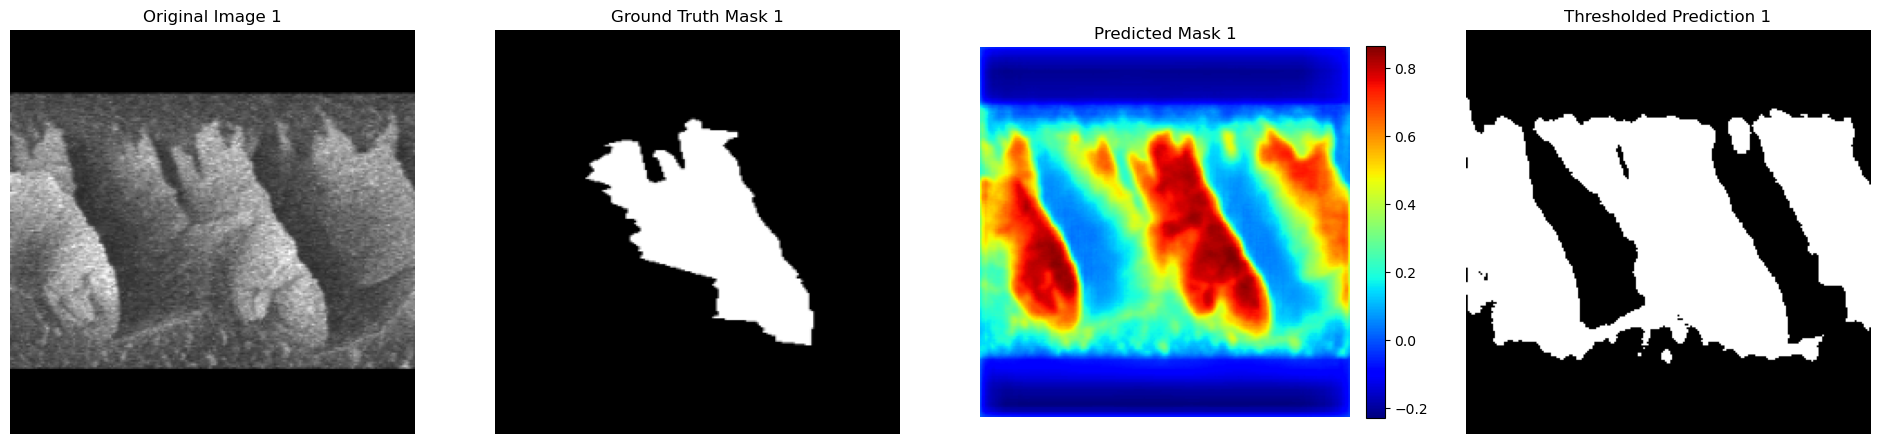

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_2.png


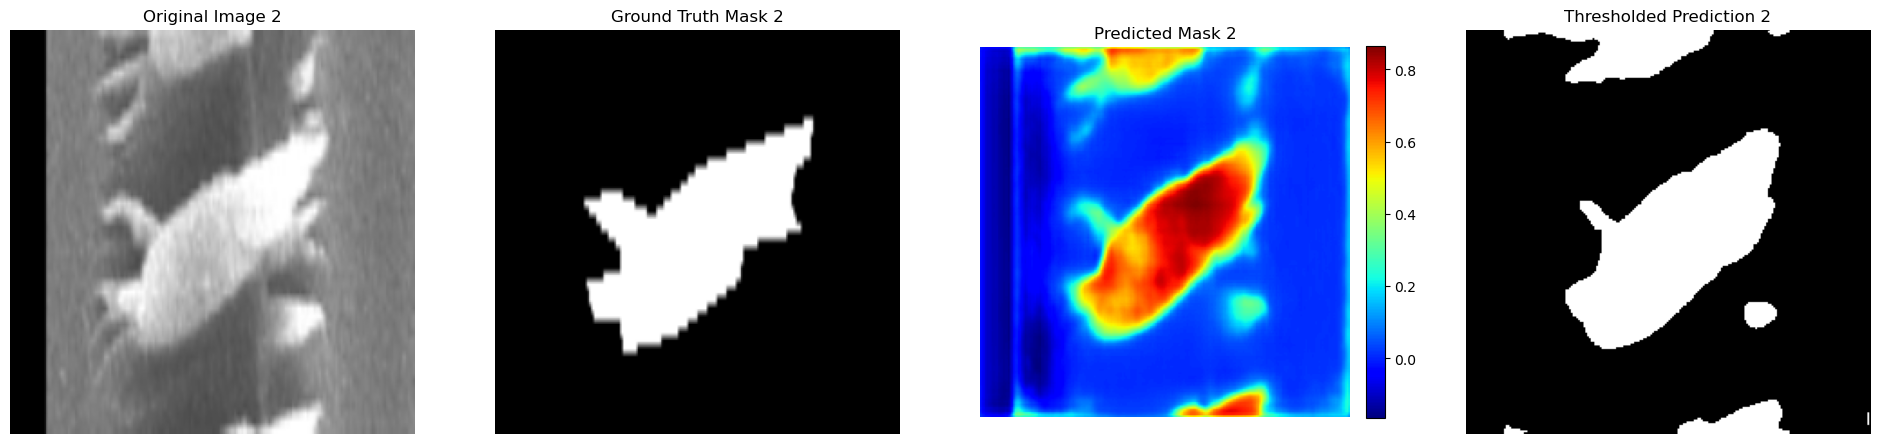

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_3.png


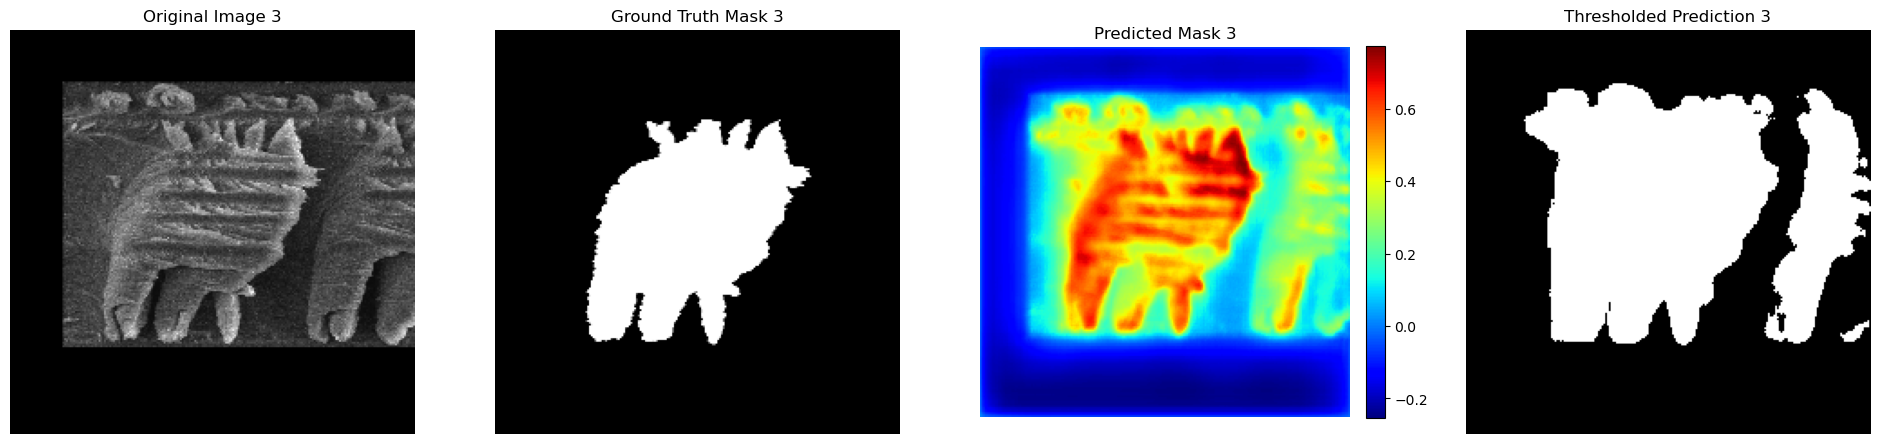

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_4.png


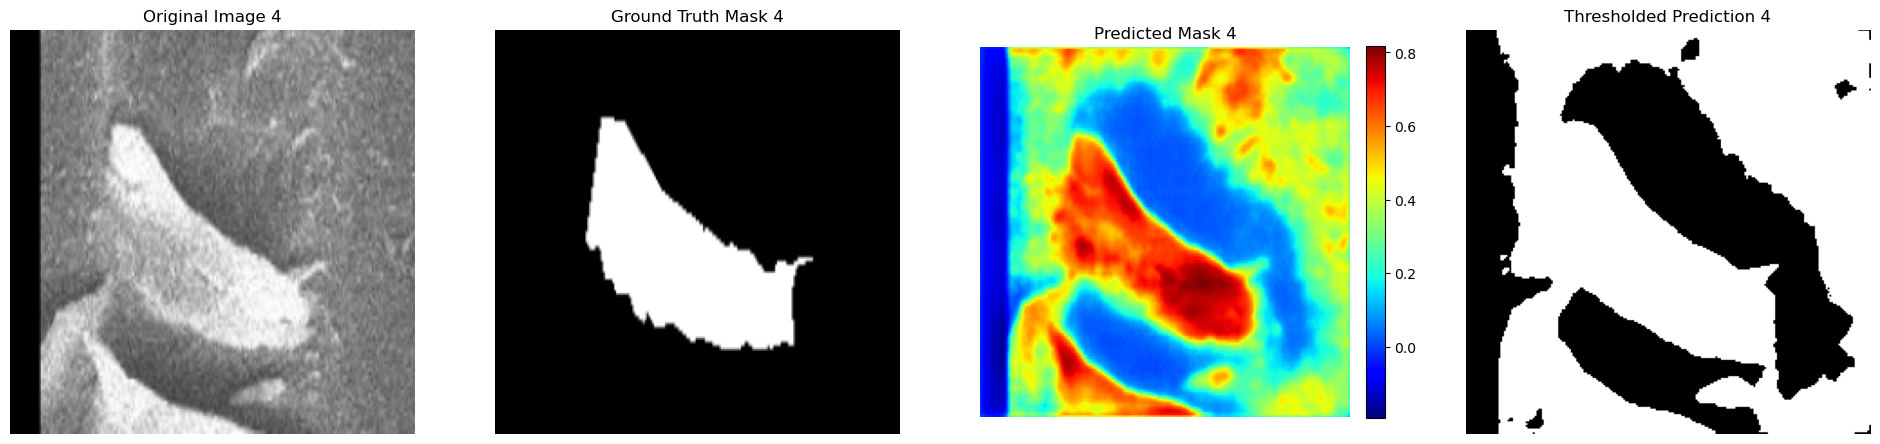

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_5.png


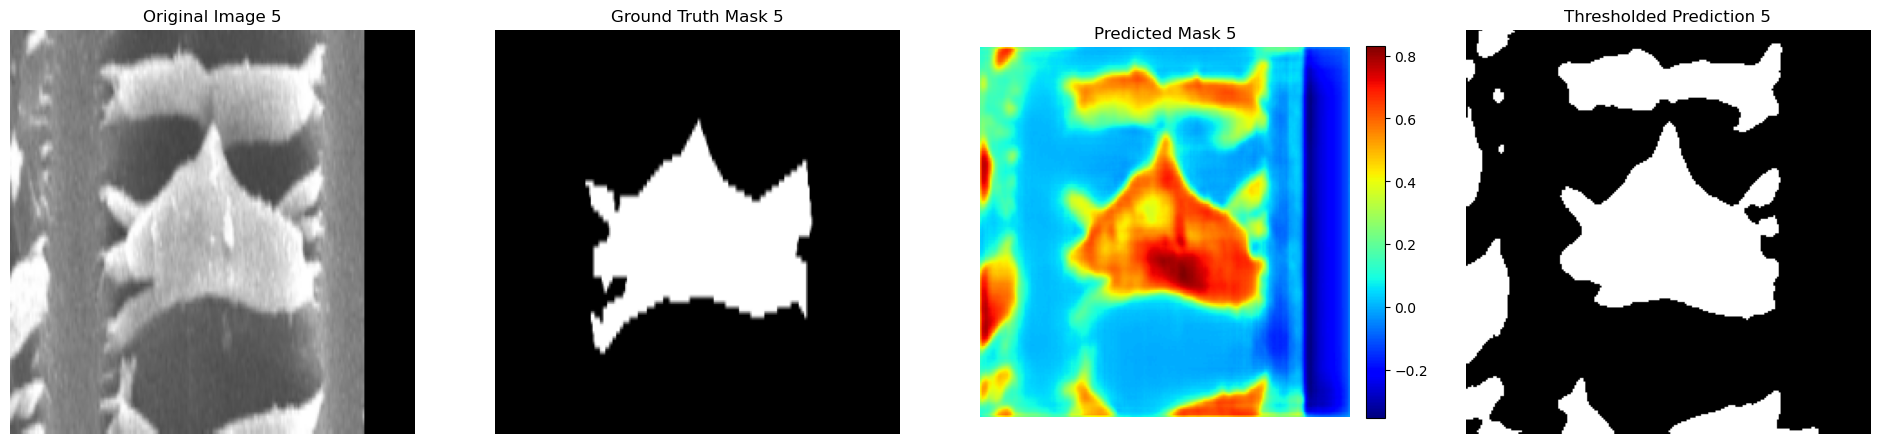

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_6.png


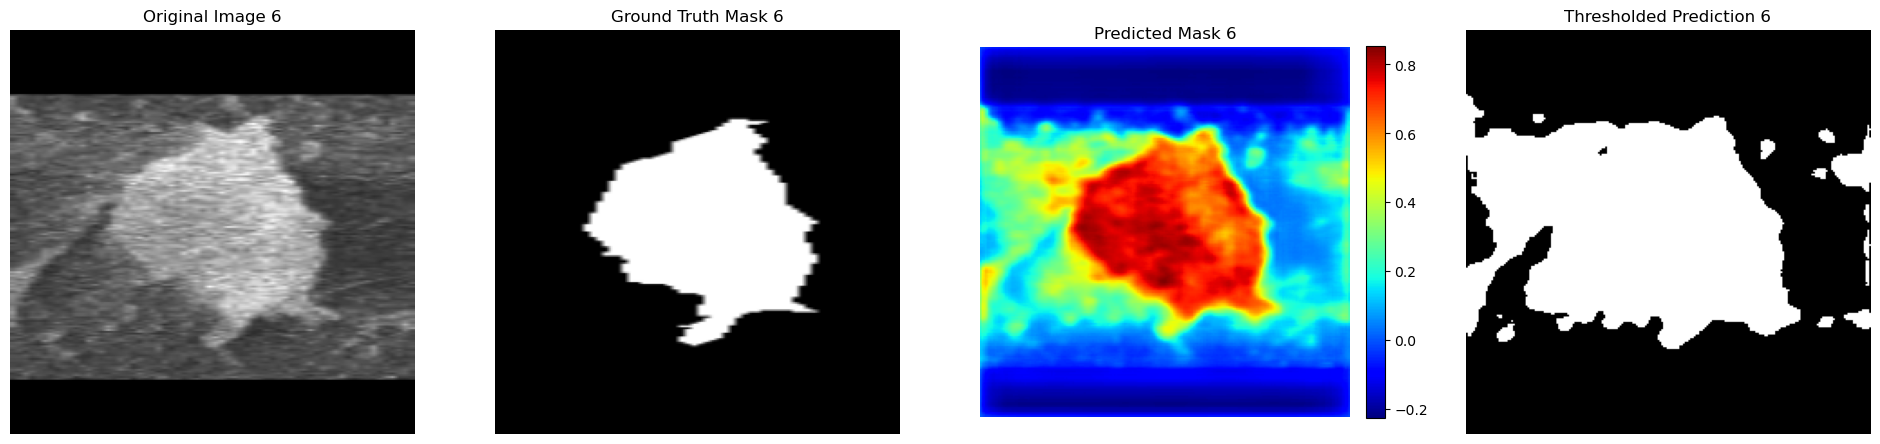

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_7.png


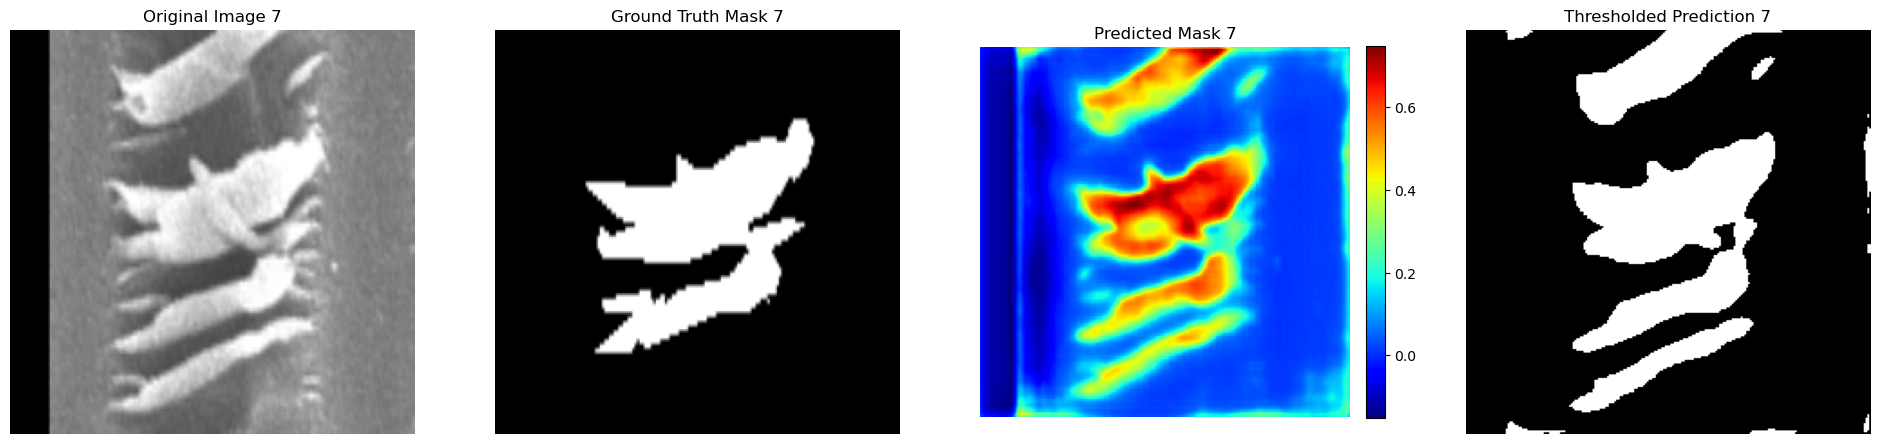

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_8.png


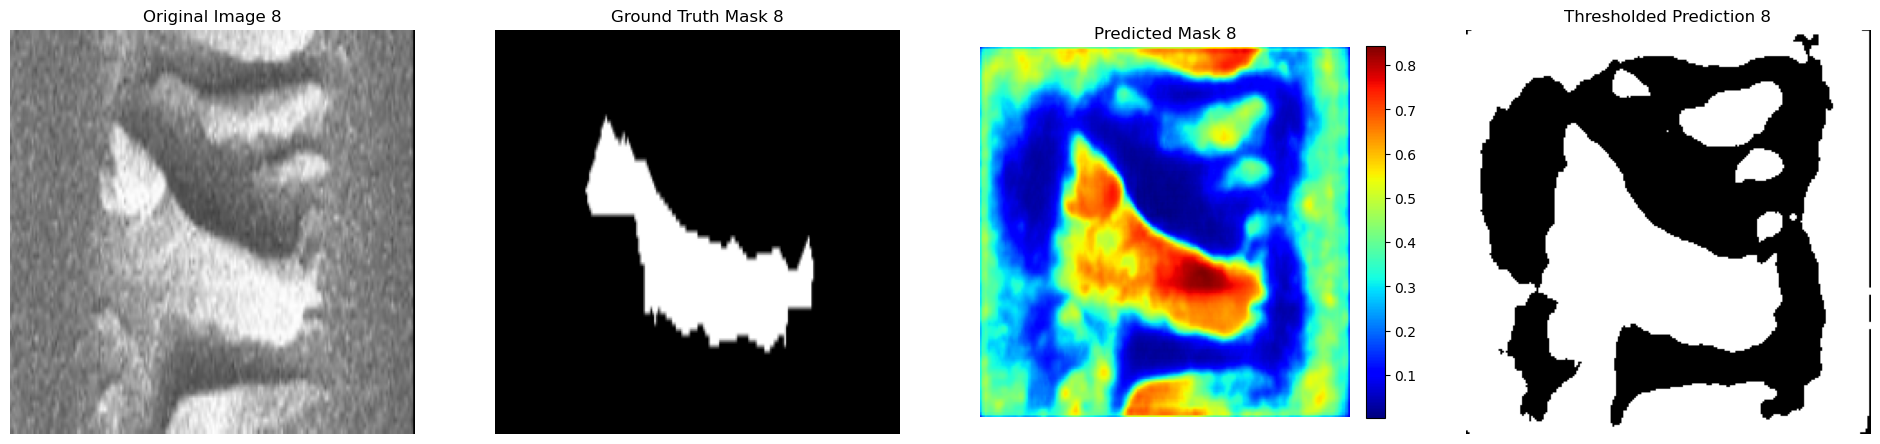

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_9.png


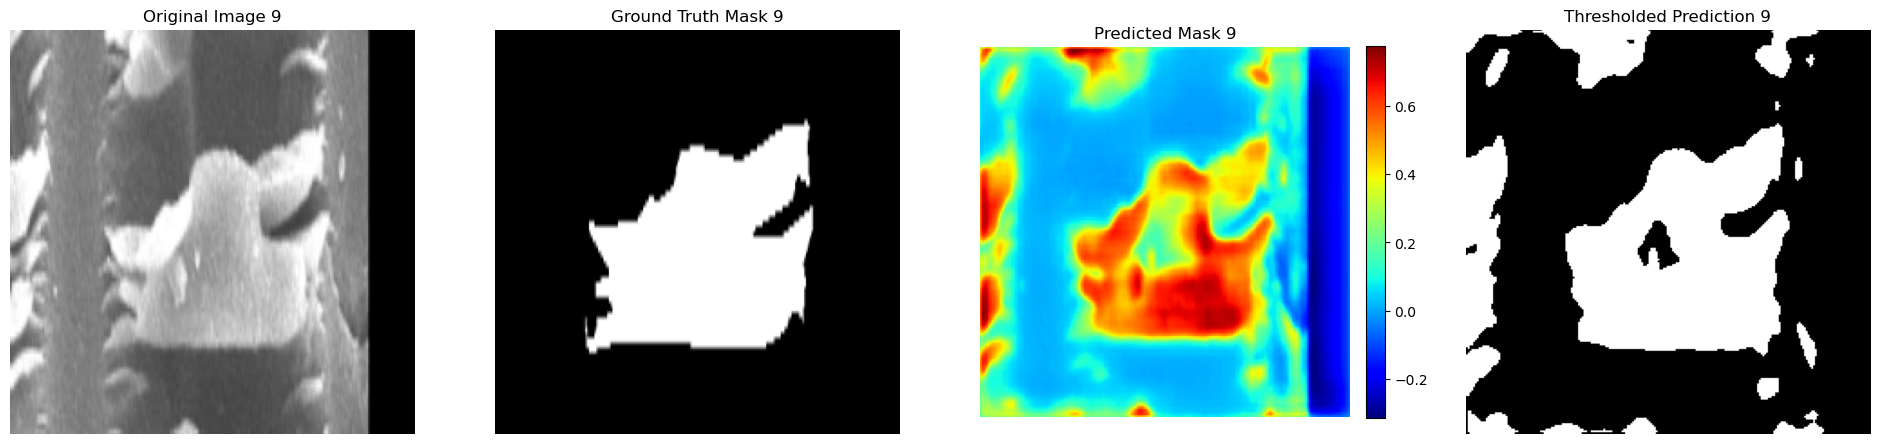

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_10.png


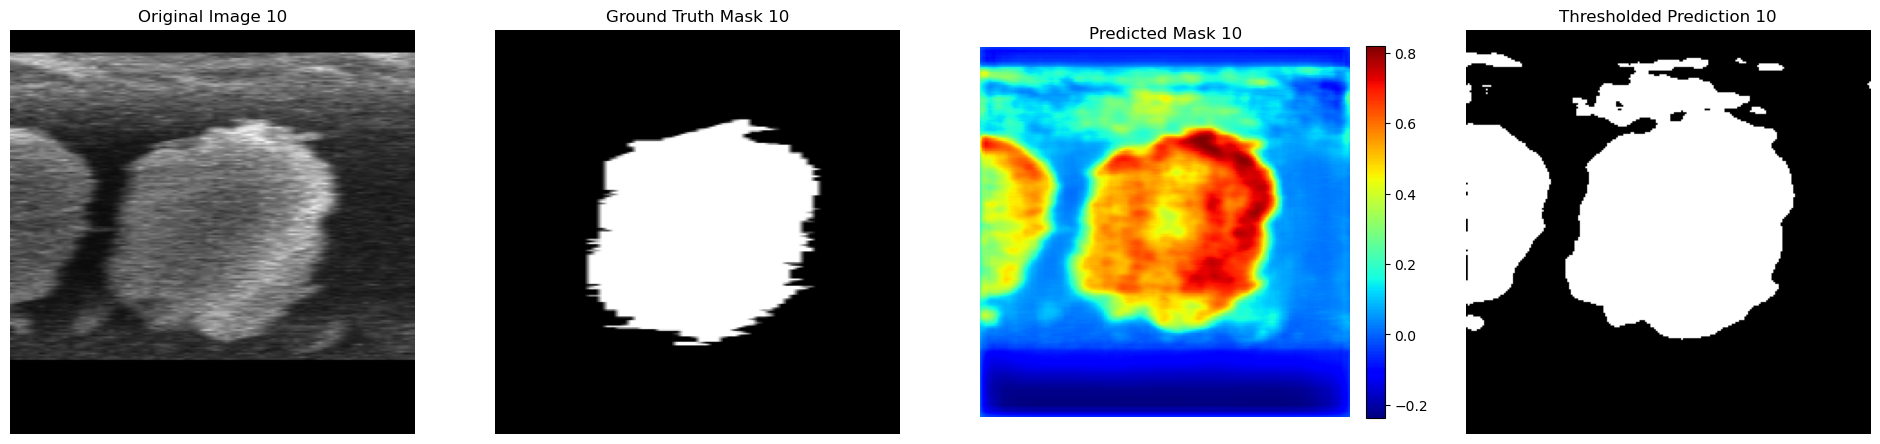

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_11.png


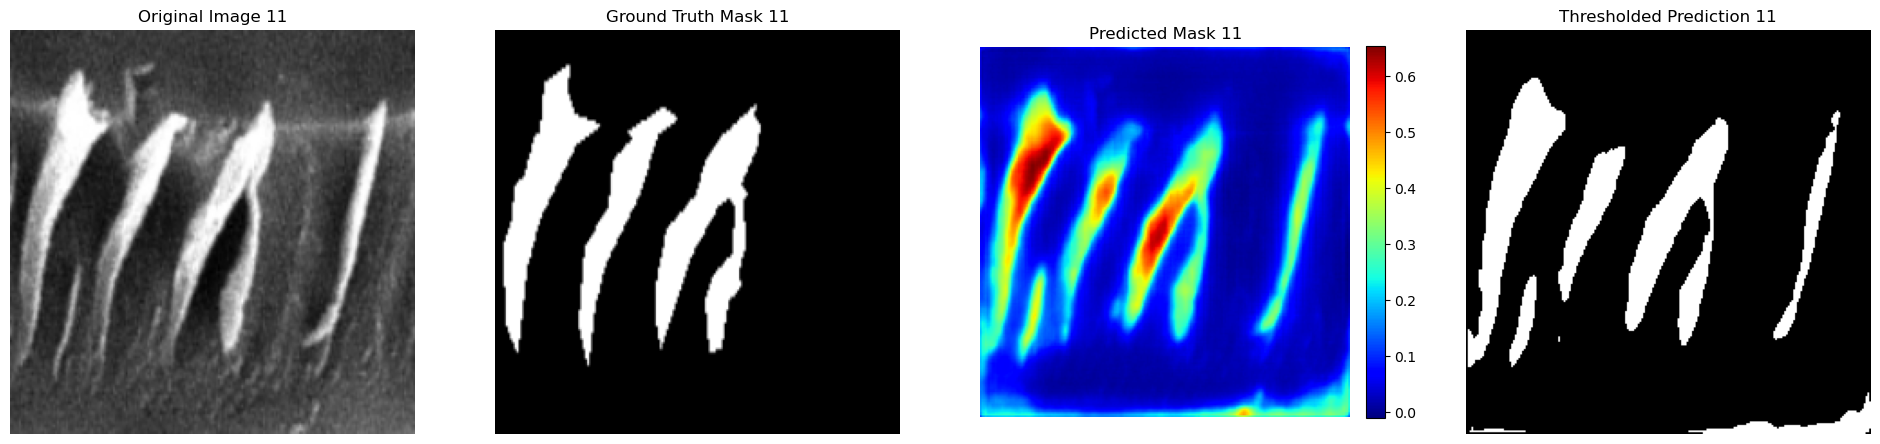

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_12.png


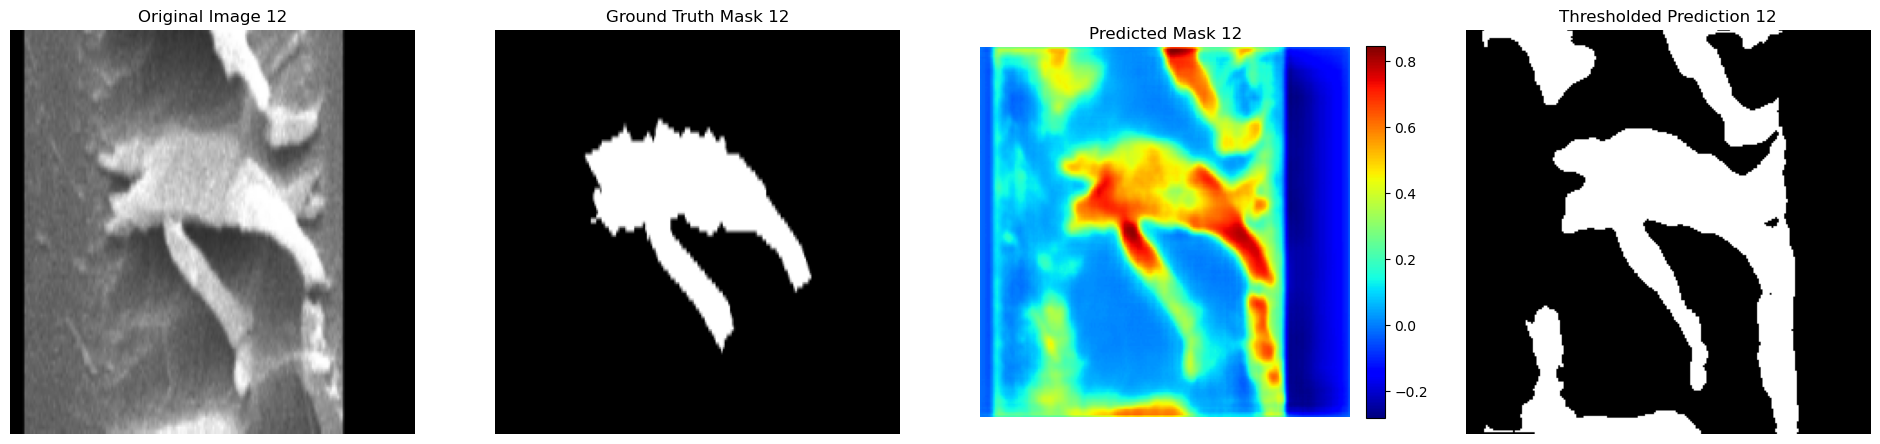

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_13.png


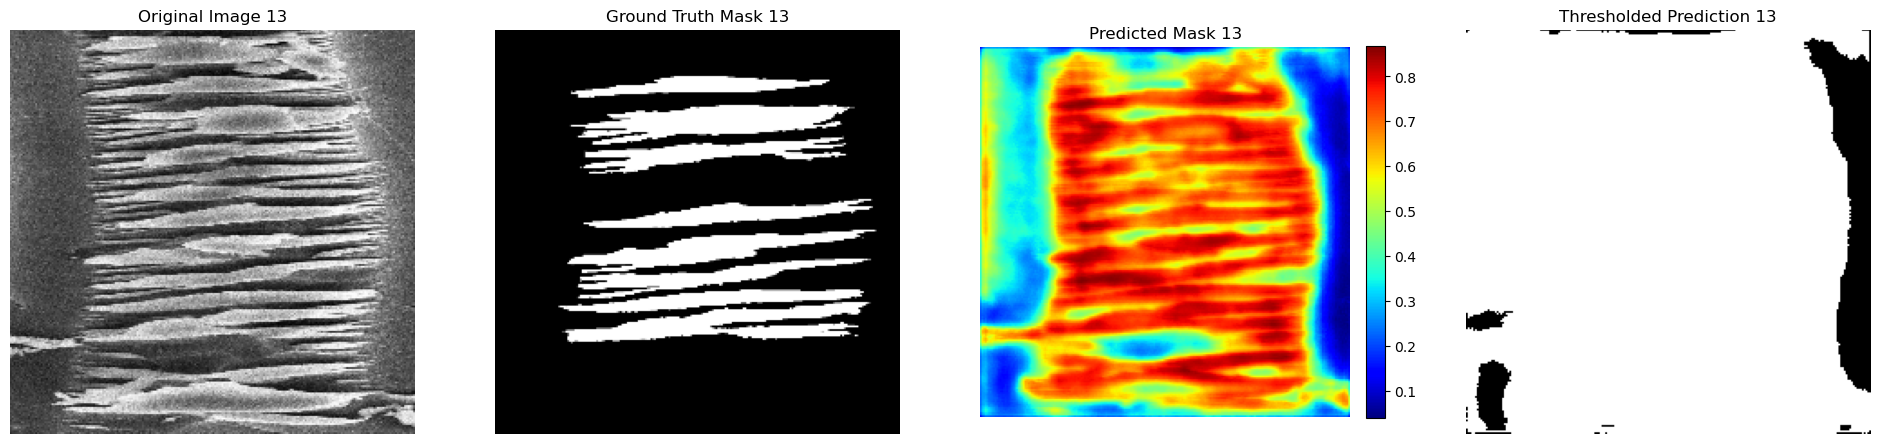

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_14.png


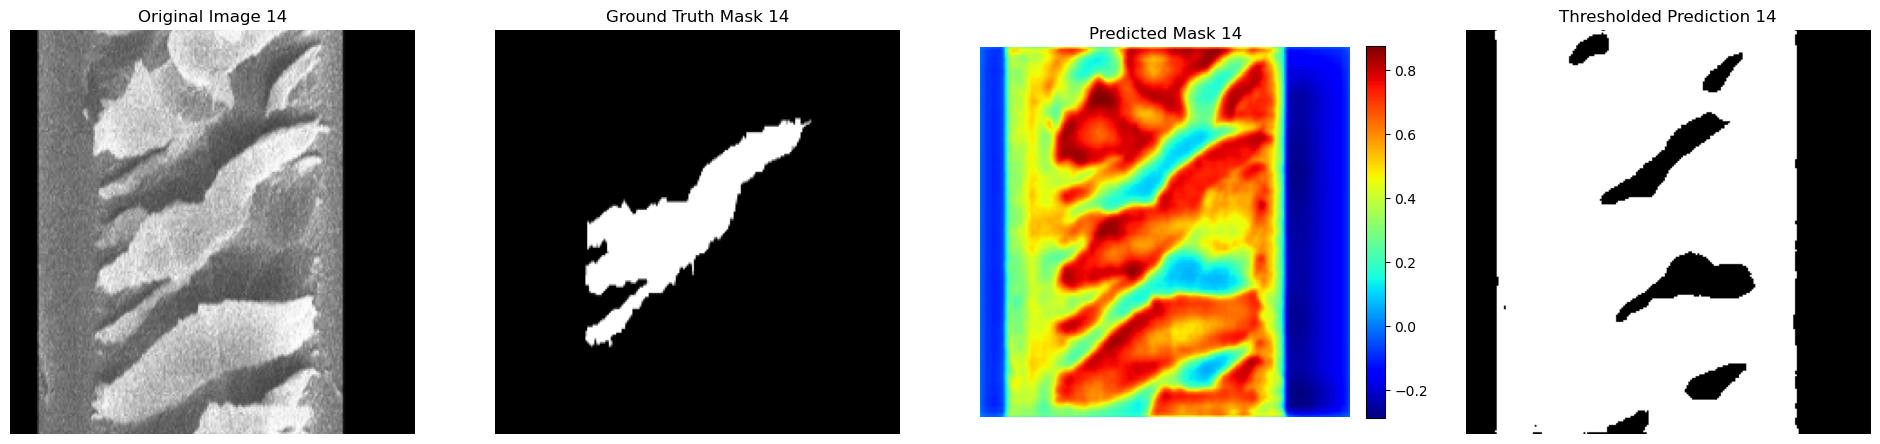

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_15.png


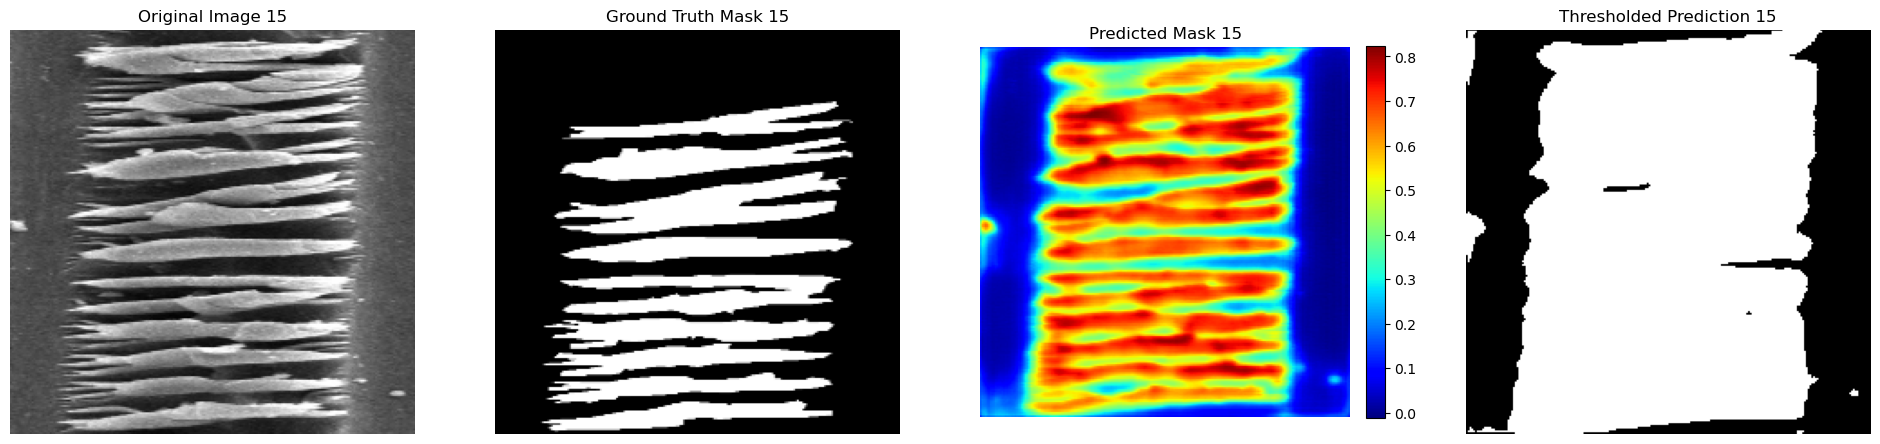

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_16.png


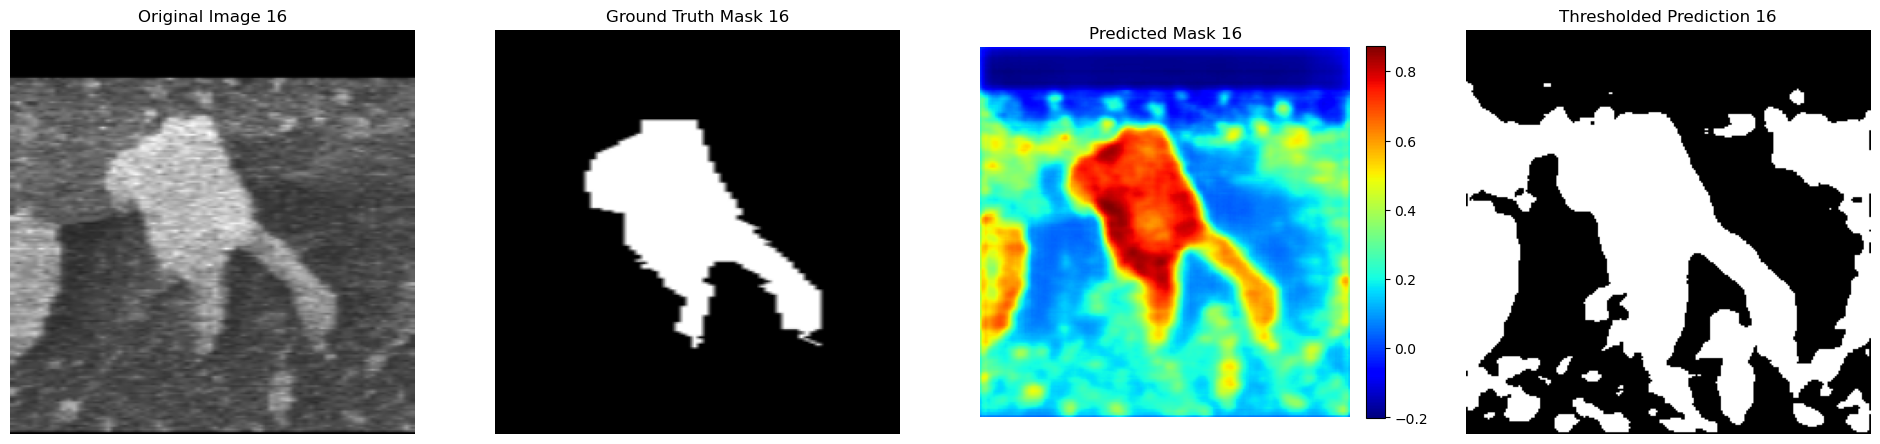

✅ Saved: /Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1/comparison_17.png


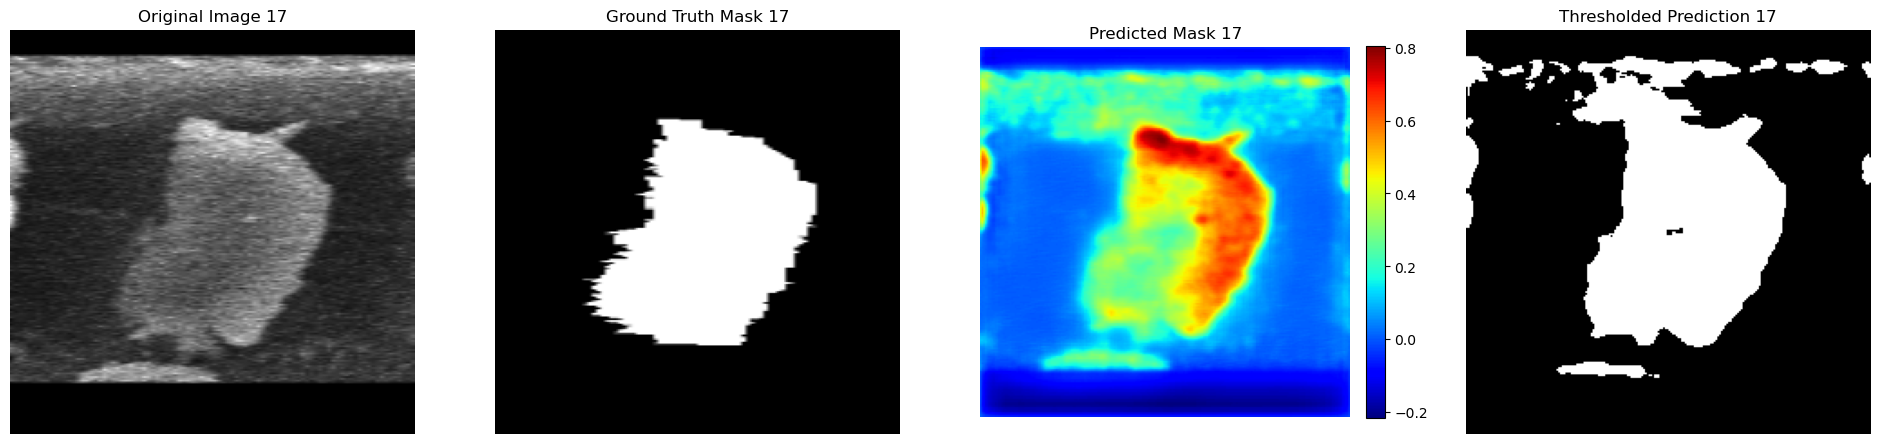

In [87]:



import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

def plot_comparison(image, true_mask, predicted_mask, threshold=0.5, index=None, save_dir="comparison_results"):
    """
    Display and save the original image, ground truth mask, predicted mask, 
    and thresholded binary mask side by side.

    Args:
        image (numpy array): Original grayscale image.
        true_mask (numpy array): Ground truth binary mask.
        predicted_mask (numpy array): Model-predicted probability mask.
        threshold (float): Threshold to binarize the predicted mask.
        index (int, optional): Image index for display title.
        save_dir (str): Directory where plots will be saved.
    """
    # Apply threshold to predicted mask
    binary_mask = (predicted_mask > threshold)  # Convert probabilities to binary

    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(24, 6))  # Create a wide figure

    # 🔹 Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original Image {index}" if index is not None else "Original Image")
    plt.axis("off")

    # 🔹 Ground Truth Mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title(f"Ground Truth Mask {index}" if index is not None else "Ground Truth Mask")
    plt.axis("off")

    # 🔹 Predicted Mask (Probability Map)
    plt.subplot(1, 4, 3)
    mask_plot = plt.imshow(predicted_mask, cmap='jet')
    plt.colorbar(mask_plot, fraction=0.046, pad=0.04)  # ✅ Add probability legend
    plt.title(f"Predicted Mask {index}" if index is not None else "Predicted Mask")
    plt.axis("off")

    # 🔹 Thresholded Binary Mask
    plt.subplot(1, 4, 4)
    plt.imshow(binary_mask, cmap='gray')
    plt.title(f"Thresholded Prediction {index}" if index is not None else "Thresholded Prediction")
    plt.axis("off")

    # Save the figure
    save_path = os.path.join(save_dir, f"comparison_{index}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"✅ Saved: {save_path}")

    plt.show()
    plt.close()  # Close the plot to free memory

# ✅ Loop over test images (show & save first 5 test images)
test_pred = model.predict(X_test)  # Predict first 5 test images

for i in range(len(test_pred)):
    img = X_test[i].squeeze()  # Original image
    true_mask = y_test[i].squeeze()  # Ground truth mask
    predicted_mask = test_pred[i].squeeze()  # Model's predicted mask

    # Display and save the four images side by side
    plot_comparison(img, true_mask, predicted_mask, threshold=0.23, index=i+1, save_dir="/Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_1")

/var/folders/67/k_t95t6n7v9grb0q17pnqqz00000gn/T/ipykernel_2853/3472861193.py:75: RuntimeWarning: invalid value encountered in cast
  cv2.imwrite(mask_path, (predicted_mask * 255).astype(np.uint8))  # Save predicted mask


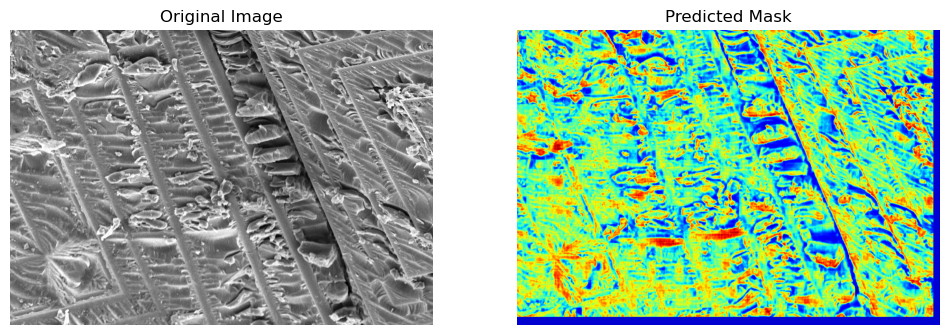

✅ Saved: sliding_window_results/1.tif


In [84]:
import numpy as np
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# ✅ Define window size and stride
WINDOW_SIZE = 112  # Size of each patch
STRIDE =56  # Overlap between patches (50% of window size)

def slide_window_predict(image, model, window_size=WINDOW_SIZE, stride=STRIDE):
    """
    Applies sliding window approach to generate a full predicted mask for a large image.

    Args:
        image (numpy array): Grayscale image to process.
        model (tf.keras.Model): Trained segmentation model.
        window_size (int): Size of each sliding window patch.
        stride (int): Step size for sliding window.

    Returns:
        numpy array: Reconstructed prediction mask for the full image.
    """
    h, w = image.shape[:2]
    full_mask = np.zeros((h, w), dtype=np.float32)
    weight_map = np.zeros((h, w), dtype=np.float32)  # Used to normalize overlapping regions

    # ✅ Slide over the image
    for y in range(0, h - window_size + 1, stride):
        for x in range(0, w - window_size + 1, stride):
            patch = image[y:y+window_size, x:x+window_size]

            # ✅ Preprocess patch for model input
            patch = patch.astype(np.float32) / 255.0
            patch = np.expand_dims(patch, axis=-1)  # Add channel
            patch = np.expand_dims(patch, axis=0)  # Add batch dimension

            # ✅ Run model prediction
            pred_patch = model.predict(patch, verbose=0)[0, :, :, 0]

            # ✅ Resize patch to match original size (if model outputs different size)
            pred_patch_resized = cv2.resize(pred_patch, (window_size, window_size))

            # ✅ Blend overlapping regions
            full_mask[y:y+window_size, x:x+window_size] += pred_patch_resized
            weight_map[y:y+window_size, x:x+window_size] += 1  # Track overlapping counts

    # ✅ Normalize overlapping regions
    full_mask /= np.maximum(weight_map, 1)

    return full_mask

def process_large_image(image_path, model, save_dir="sliding_window_results"):
    """
    Loads a large image, applies sliding window segmentation, and saves the results.

    Args:
        image_path (str): Path to the input image.
        model (tf.keras.Model): Trained segmentation model.
        save_dir (str): Directory to save the results.
    """
    os.makedirs(save_dir, exist_ok=True)

    # ✅ Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # ✅ Predict full mask using sliding window approach
    predicted_mask = slide_window_predict(image, model)

    # ✅ Save original image and predicted mask
    save_path = os.path.join(save_dir, os.path.basename(image_path))
    mask_path = save_path.replace(".png", "_predicted_mask.png")

    cv2.imwrite(save_path, image)  # Save original image
    cv2.imwrite(mask_path, (predicted_mask * 255).astype(np.uint8))  # Save predicted mask

    # ✅ Display results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="jet")
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()
    print(f"✅ Saved: {mask_path}")
    return predicted_mask
# ✅ Example Usage
image_path = "/Users/rfalcao/Documents/FYP/ClearCuspsCroppedRotated/1.tif"  # Replace with actual path
pred=process_large_image(image_path, model)

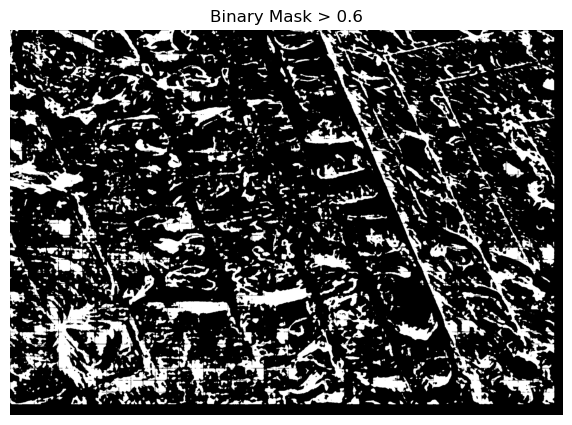

In [85]:
plt.figure(figsize=(12, 5))
    
bin=pred>0.5
plt.imshow(bin, cmap="gray")
plt.title("Binary Mask > 0.6")
plt.axis("off")
plt.savefig("/Users/rfalcao/Documents/FYP/Cusp Images_081224/annotations 4/patches128/plots_tune_2/window.png", bbox_inches='tight', dpi=300)